# Tutorial for analysis of unique representation learned by `PICASA` using breast cancer dataset.

In [1]:

import anndata as ad
import pandas as pd
import os 
import glob 
from picasa import model,dutil
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scvi.distributions import ZeroInflatedNegativeBinomial
import scanpy as sc
import infercnvpy as cnv


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


sample ='brca'
pp = '/home/BCCRC.CA/ssubedi/projects/experiments/picasa/picasa_reproducibility/analysis/'


/home/BCCRC.CA/ssubedi/miniconda3/envs/scvi-env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
wdir = pp+sample
picasa_adata = ad.read_h5ad(wdir+'/model_results/picasa.h5ad')
adata = ad.read_h5ad(wdir+'/model_data/all_brca.h5ad')

For each patient get reconstructed gene expression data based on only unique representation using trained `PICASA` model.

In [3]:
def get_zinb_reconstruction(x, px_s, px_r, px_d):
	zinb_dist = ZeroInflatedNegativeBinomial(mu=px_s, theta=px_r, zi_logits=px_d)
	reconstructed_x = zinb_dist.sample()
	return reconstructed_x


num_batches = len(picasa_adata.obs['batch'].unique())
input_dim = adata.shape[1]
nn_params = picasa_adata.uns['nn_params']
enc_layers = [128,25]
unique_latent_dim = nn_params['latent_dim']
common_latent_dim = nn_params['latent_dim']
dec_layers = [128,128]
nn_params['device'] = 'cpu'


picasa_unique_model = model.PICASAUniqueNet(input_dim,common_latent_dim,unique_latent_dim,enc_layers,dec_layers,num_batches).to(nn_params['device'])
picasa_unique_model.load_state_dict(torch.load(wdir+'/model_results/picasa_unique.model', weights_only=True,map_location=torch.device(nn_params['device'])))

picasa_unique_model.eval()

df_recons = pd.DataFrame()

for p1 in adata.obs['batch'].unique():
	
	print(p1)
	
	current_adata = adata[adata.obs['batch']==p1].copy()
 
	df = current_adata.to_df()

	x_c1 = torch.tensor(df.values).float()
	x_z = torch.tensor(pd.DataFrame(np.zeros((df.shape[0],25))).values).float()
	y = current_adata.obs_names.values

	z,ylabel = model.predict_batch_unique(picasa_unique_model,x_c1,y,x_z)
	z_u = z[0]
	px_scale = z[1]
	px_rate = z[2]
	px_dropout = z[3]
	batch_pred = z[4]



	x_recons = get_zinb_reconstruction(x_c1,px_scale,px_rate,px_dropout)
	df_recons_current = pd.DataFrame(x_recons.detach().numpy(),index=df.index.values,columns = df.columns)
	df_recons = pd.concat([df_recons,df_recons_current])


adata_recons = ad.AnnData(df_recons)

CID4495
CID3586
CID3838
CID3921
CID3948
CID4040
CID4066
CID4067
CID4290A
CID4398
CID44041
CID4471
CID44971
CID44991
CID4515
CID45171
CID4535
CID4530N
CID4513
CID3963
CID4523


Prepare for cnv analysis. 

In [4]:
df_obs = picasa_adata.obs.copy()
df_obs.index = [x.split('@')[0] for x in df_obs.index.values]

df_gene = pd.read_csv(wdir+'/model_data/df_gene_coord.csv.gz',index_col=0)

Get original expression data to calculate cnv profile using original expression data. 

In [5]:
tag = 'orig'
df_expr = adata.to_df() ## 72k x 25k

present_genes = [ x for x in df_expr.columns if x  in df_gene.index.values]
## 24k genes found to have coordiante

df_gene = df_gene.loc[present_genes]
df_expr = df_expr.loc[:,present_genes]
df_obs = df_obs.loc[df_expr.index.values]

Calculate CNV profile for original data.

  0%|          | 0/18 [00:00<?, ?it/s]

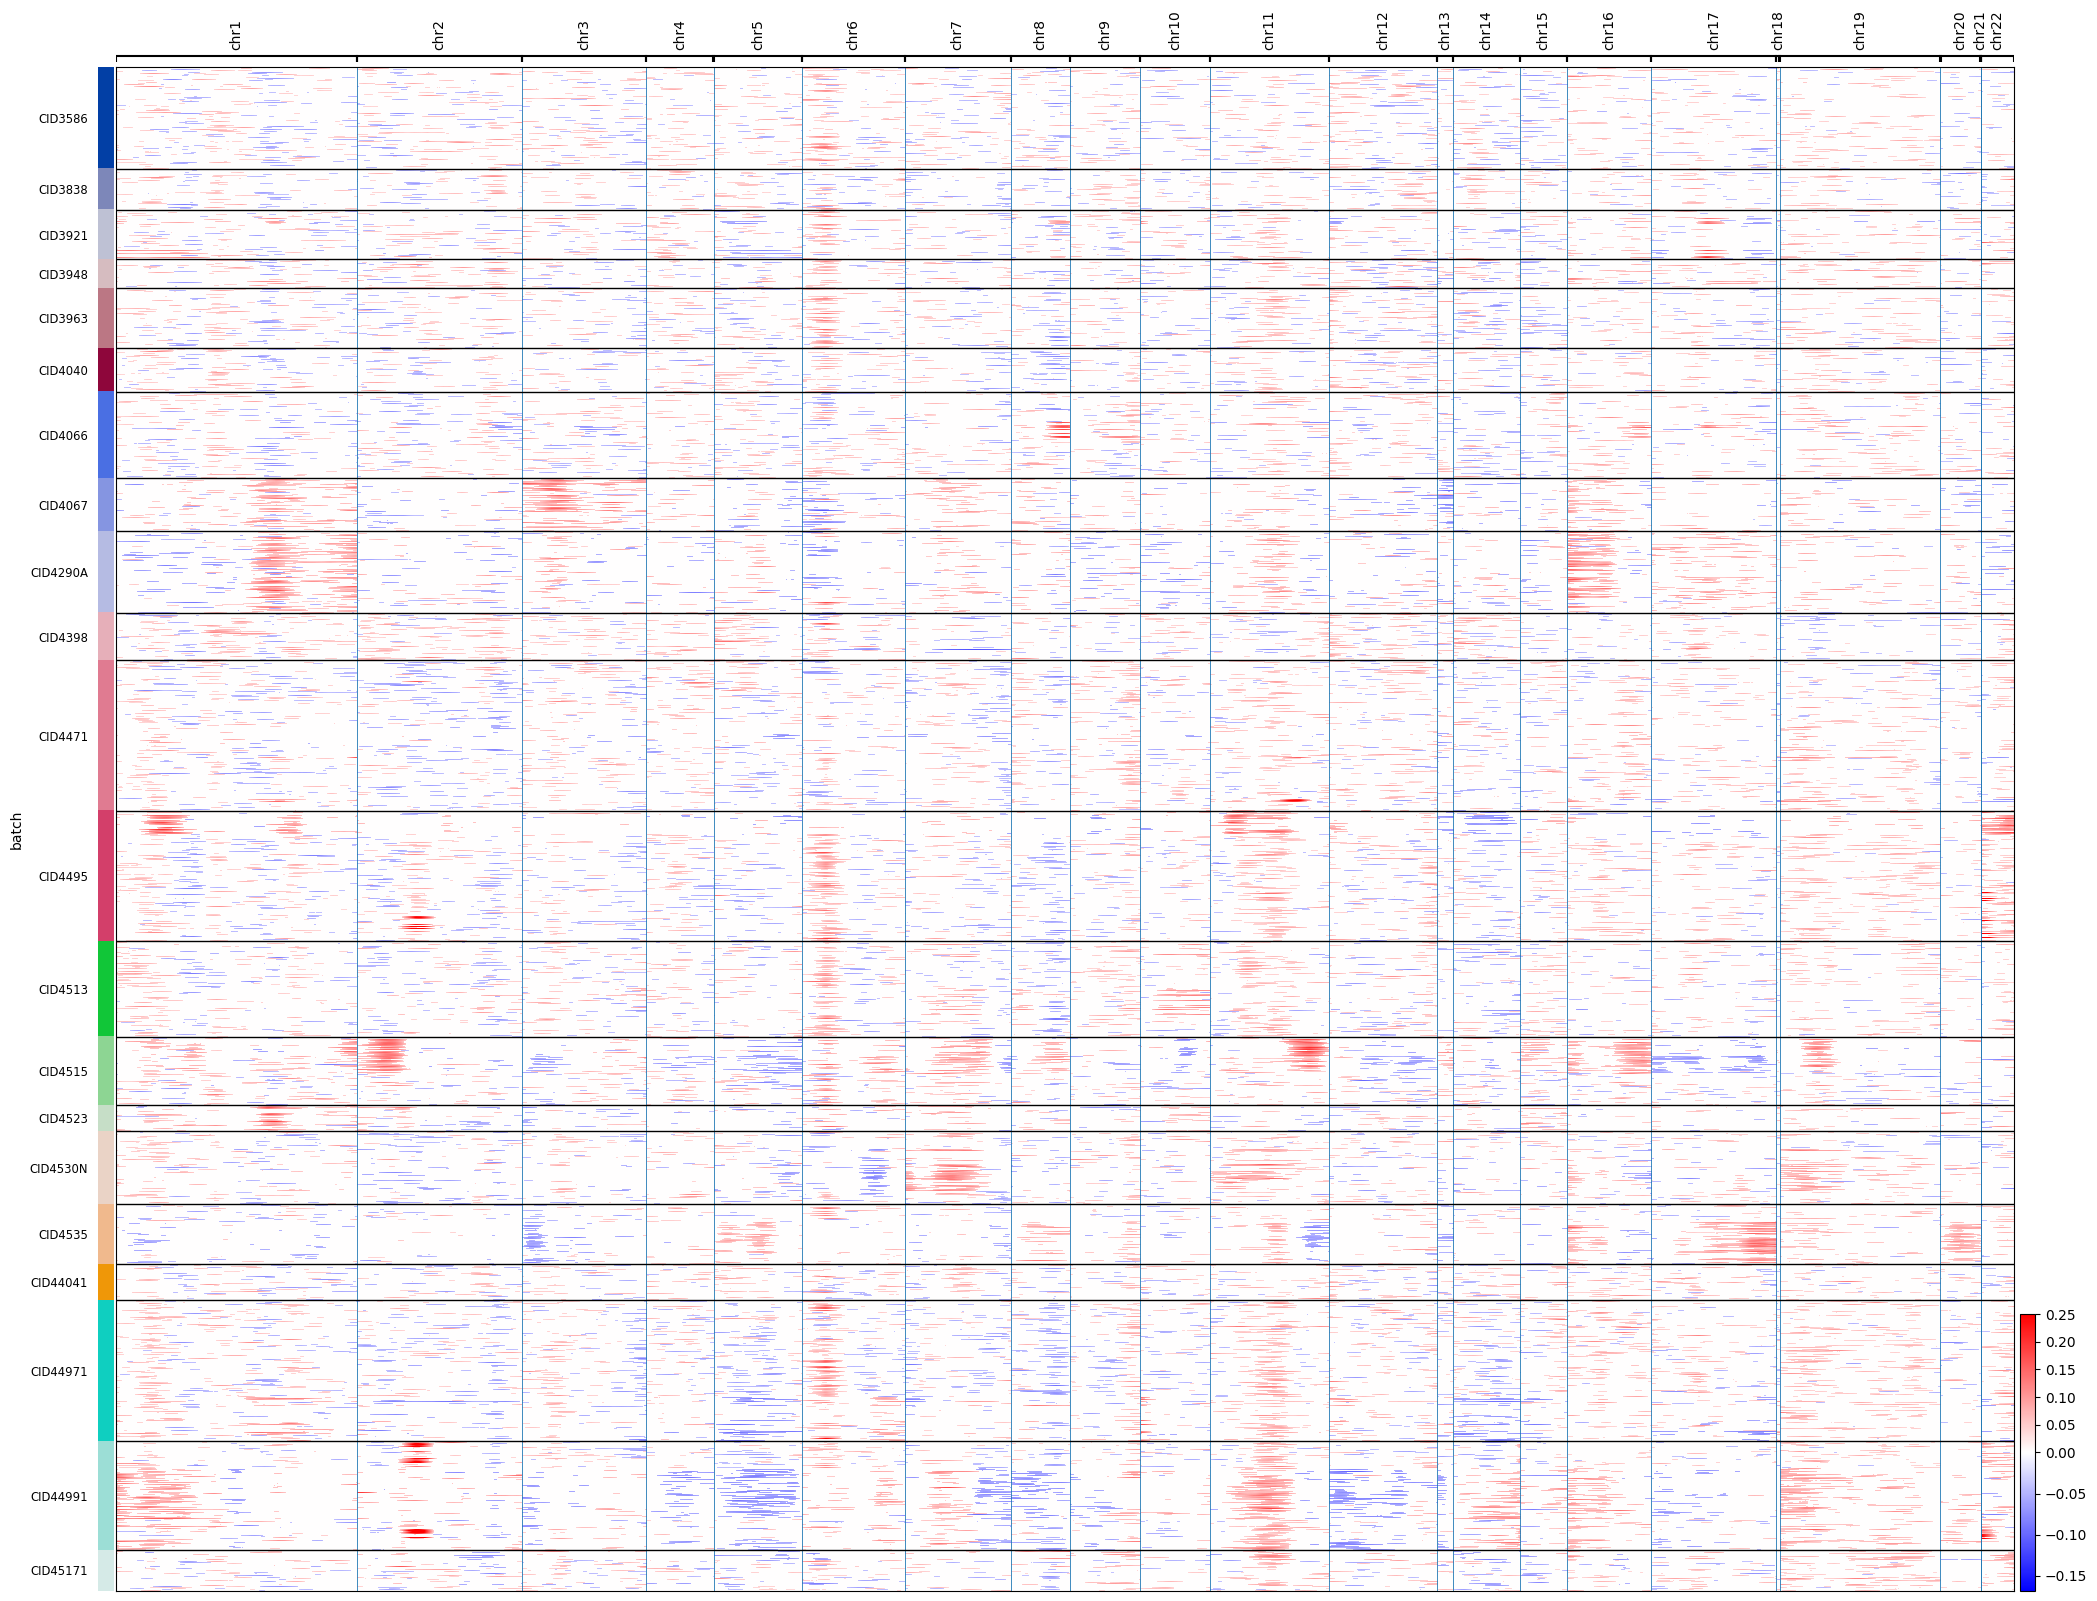

In [6]:

adata = ad.AnnData(df_expr)
adata.obs_names = df_expr.index.values
adata.var_names = df_expr.columns.values
adata.var = df_gene
adata.obs = df_obs

cats = adata.obs.batch.unique().tolist()


cnv.tl.infercnv(
    adata,
    reference_key="batch",
    reference_cat = cats,
    window_size=250,
    step=1	
    )


df_org = pd.DataFrame(adata.obsm['X_cnv'].todense())
df_org.index = adata.obs.index.values

adata.obsm['X_cnv'].data = np.clip(adata.obsm['X_cnv'].data, -0.25, 0.25)

cnv.pl.chromosome_heatmap(adata, 
    figsize=(25, 20),
    groupby="batch")

Calculate CNV profile for reconstructed data.

In [6]:
tag='recons'
df_expr = adata_recons.to_df()
df_expr = df_expr.loc[:,present_genes]

  0%|          | 0/18 [00:00<?, ?it/s]

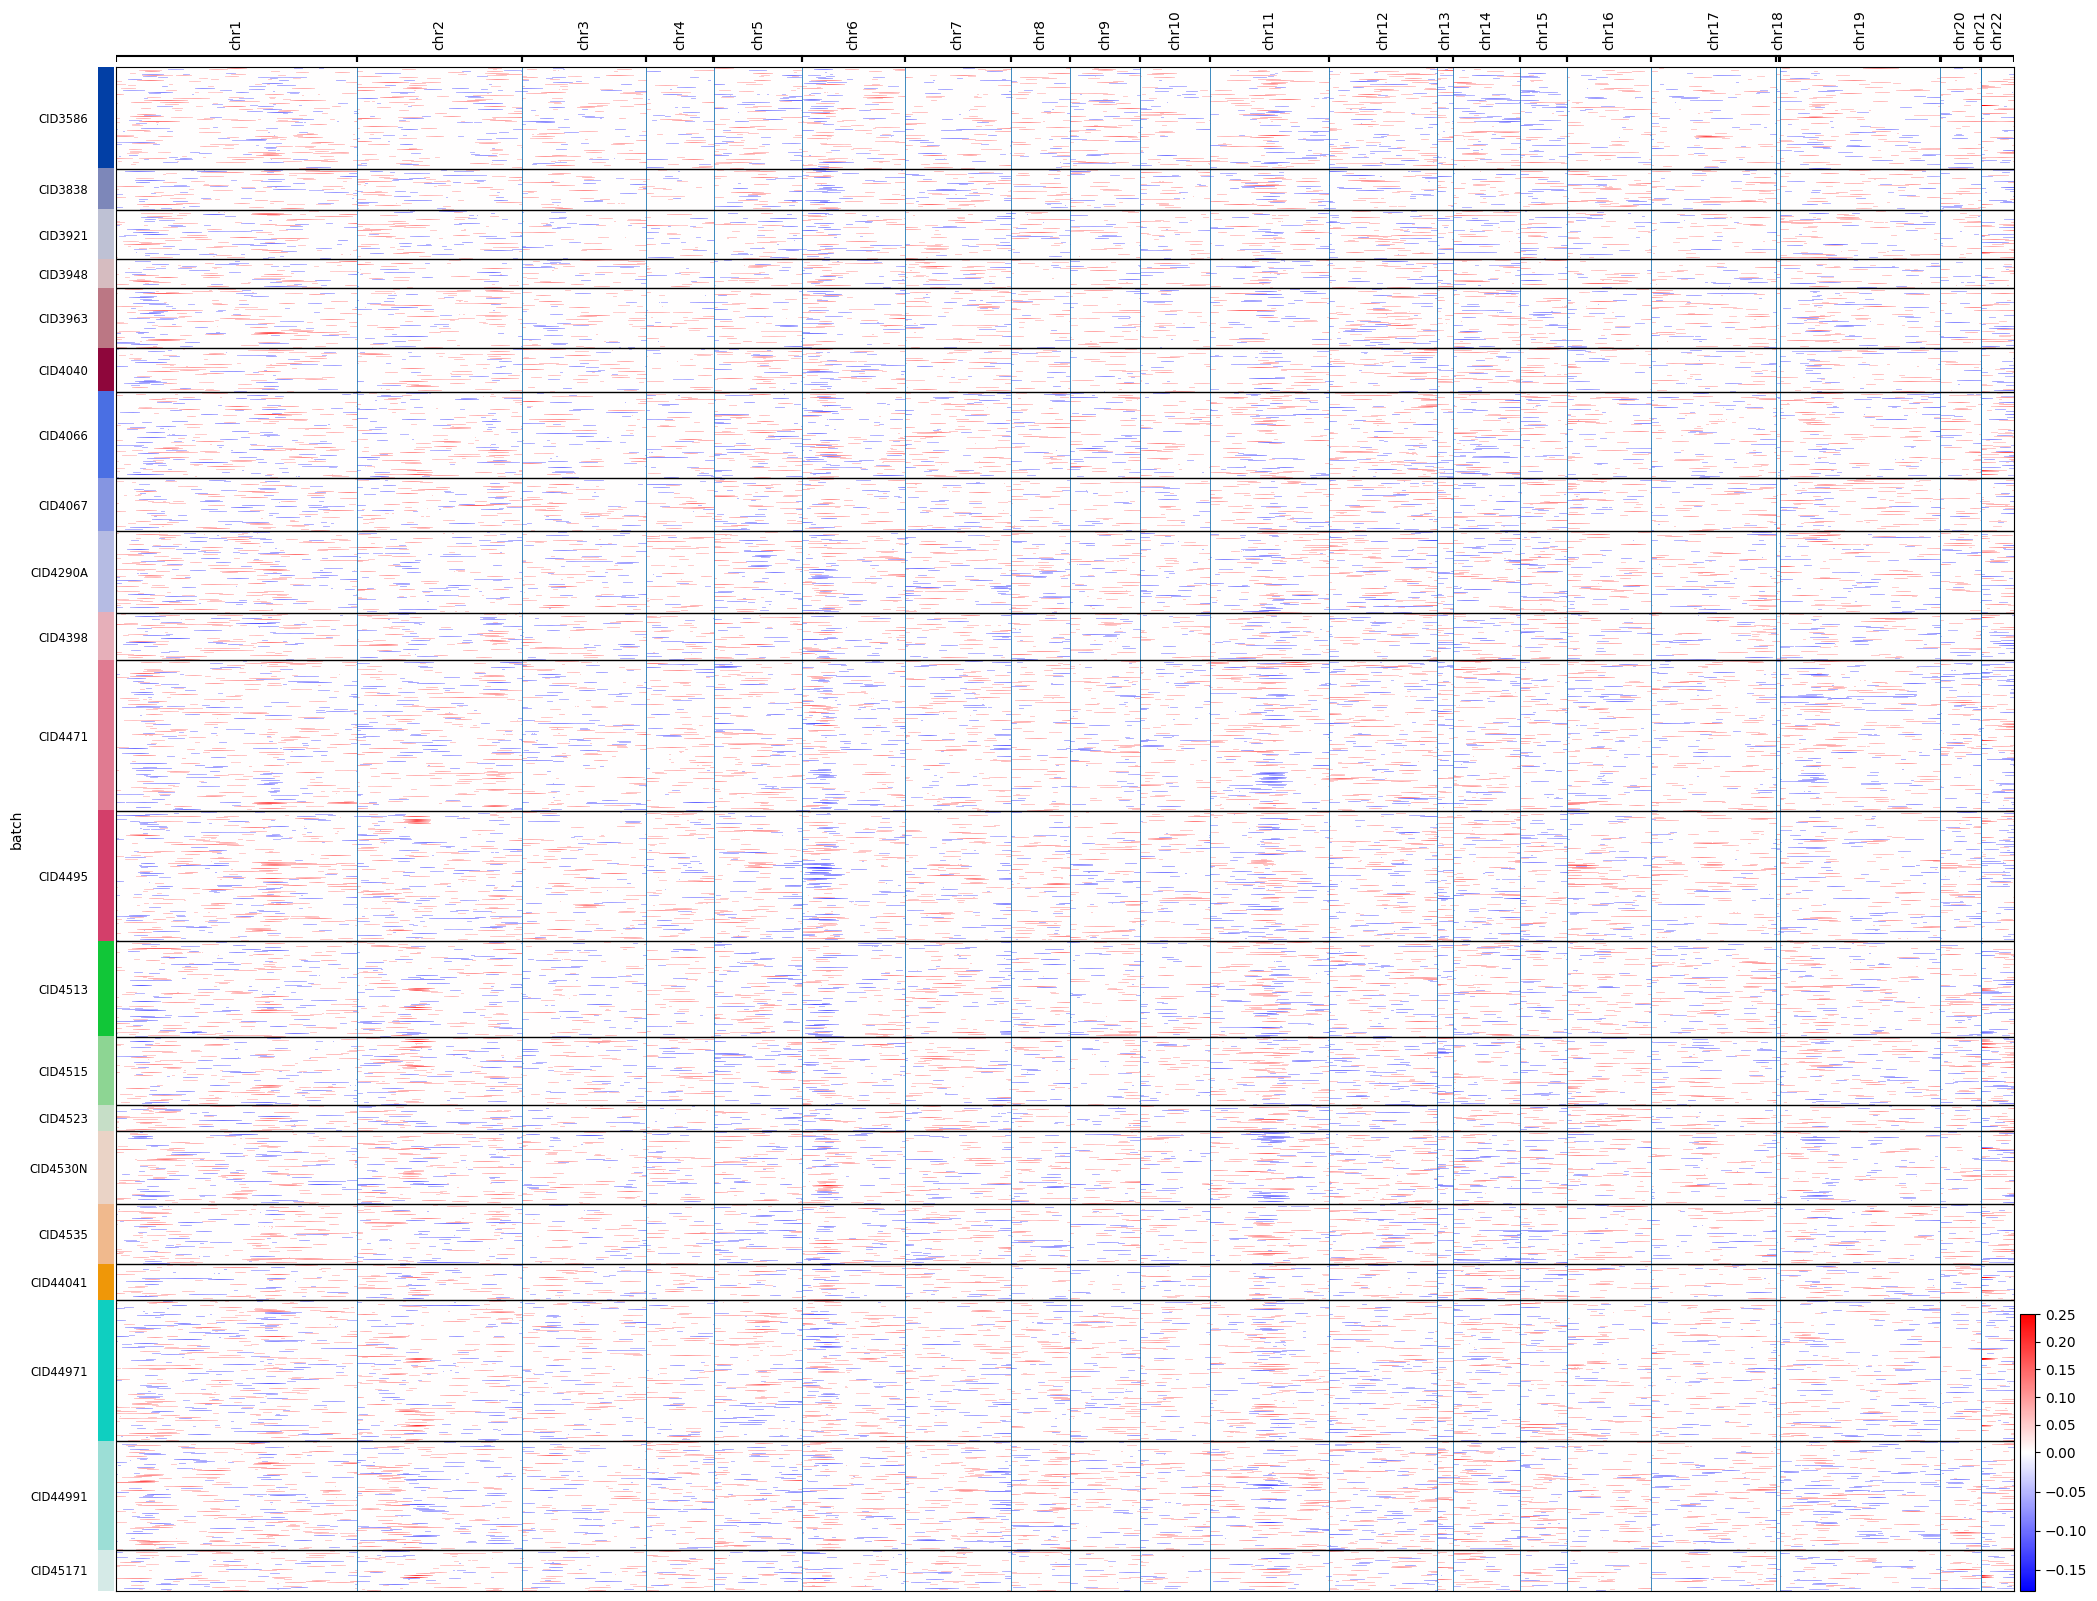

In [7]:

adata = ad.AnnData(df_expr)
adata.obs_names = df_expr.index.values
adata.var_names = df_expr.columns.values
adata.var = df_gene
adata.obs = df_obs

cats = adata.obs.batch.unique().tolist()


cnv.tl.infercnv(
    adata,
    reference_key="batch",
    reference_cat = cats,
    window_size=250,
    step=1	
    )

df_rec = pd.DataFrame(adata.obsm['X_cnv'].todense())
df_rec.index = adata.obs.index.values

adata.obsm['X_cnv'].data = np.clip(adata.obsm['X_cnv'].data, -0.25, 0.25)

cnv.pl.chromosome_heatmap(adata, 
    figsize=(25, 20),
    groupby="batch")

Calculate patient-wise correlation based on CNV profiles generated by original gene expressioin data vs. reconstructed data based on unique representation. 

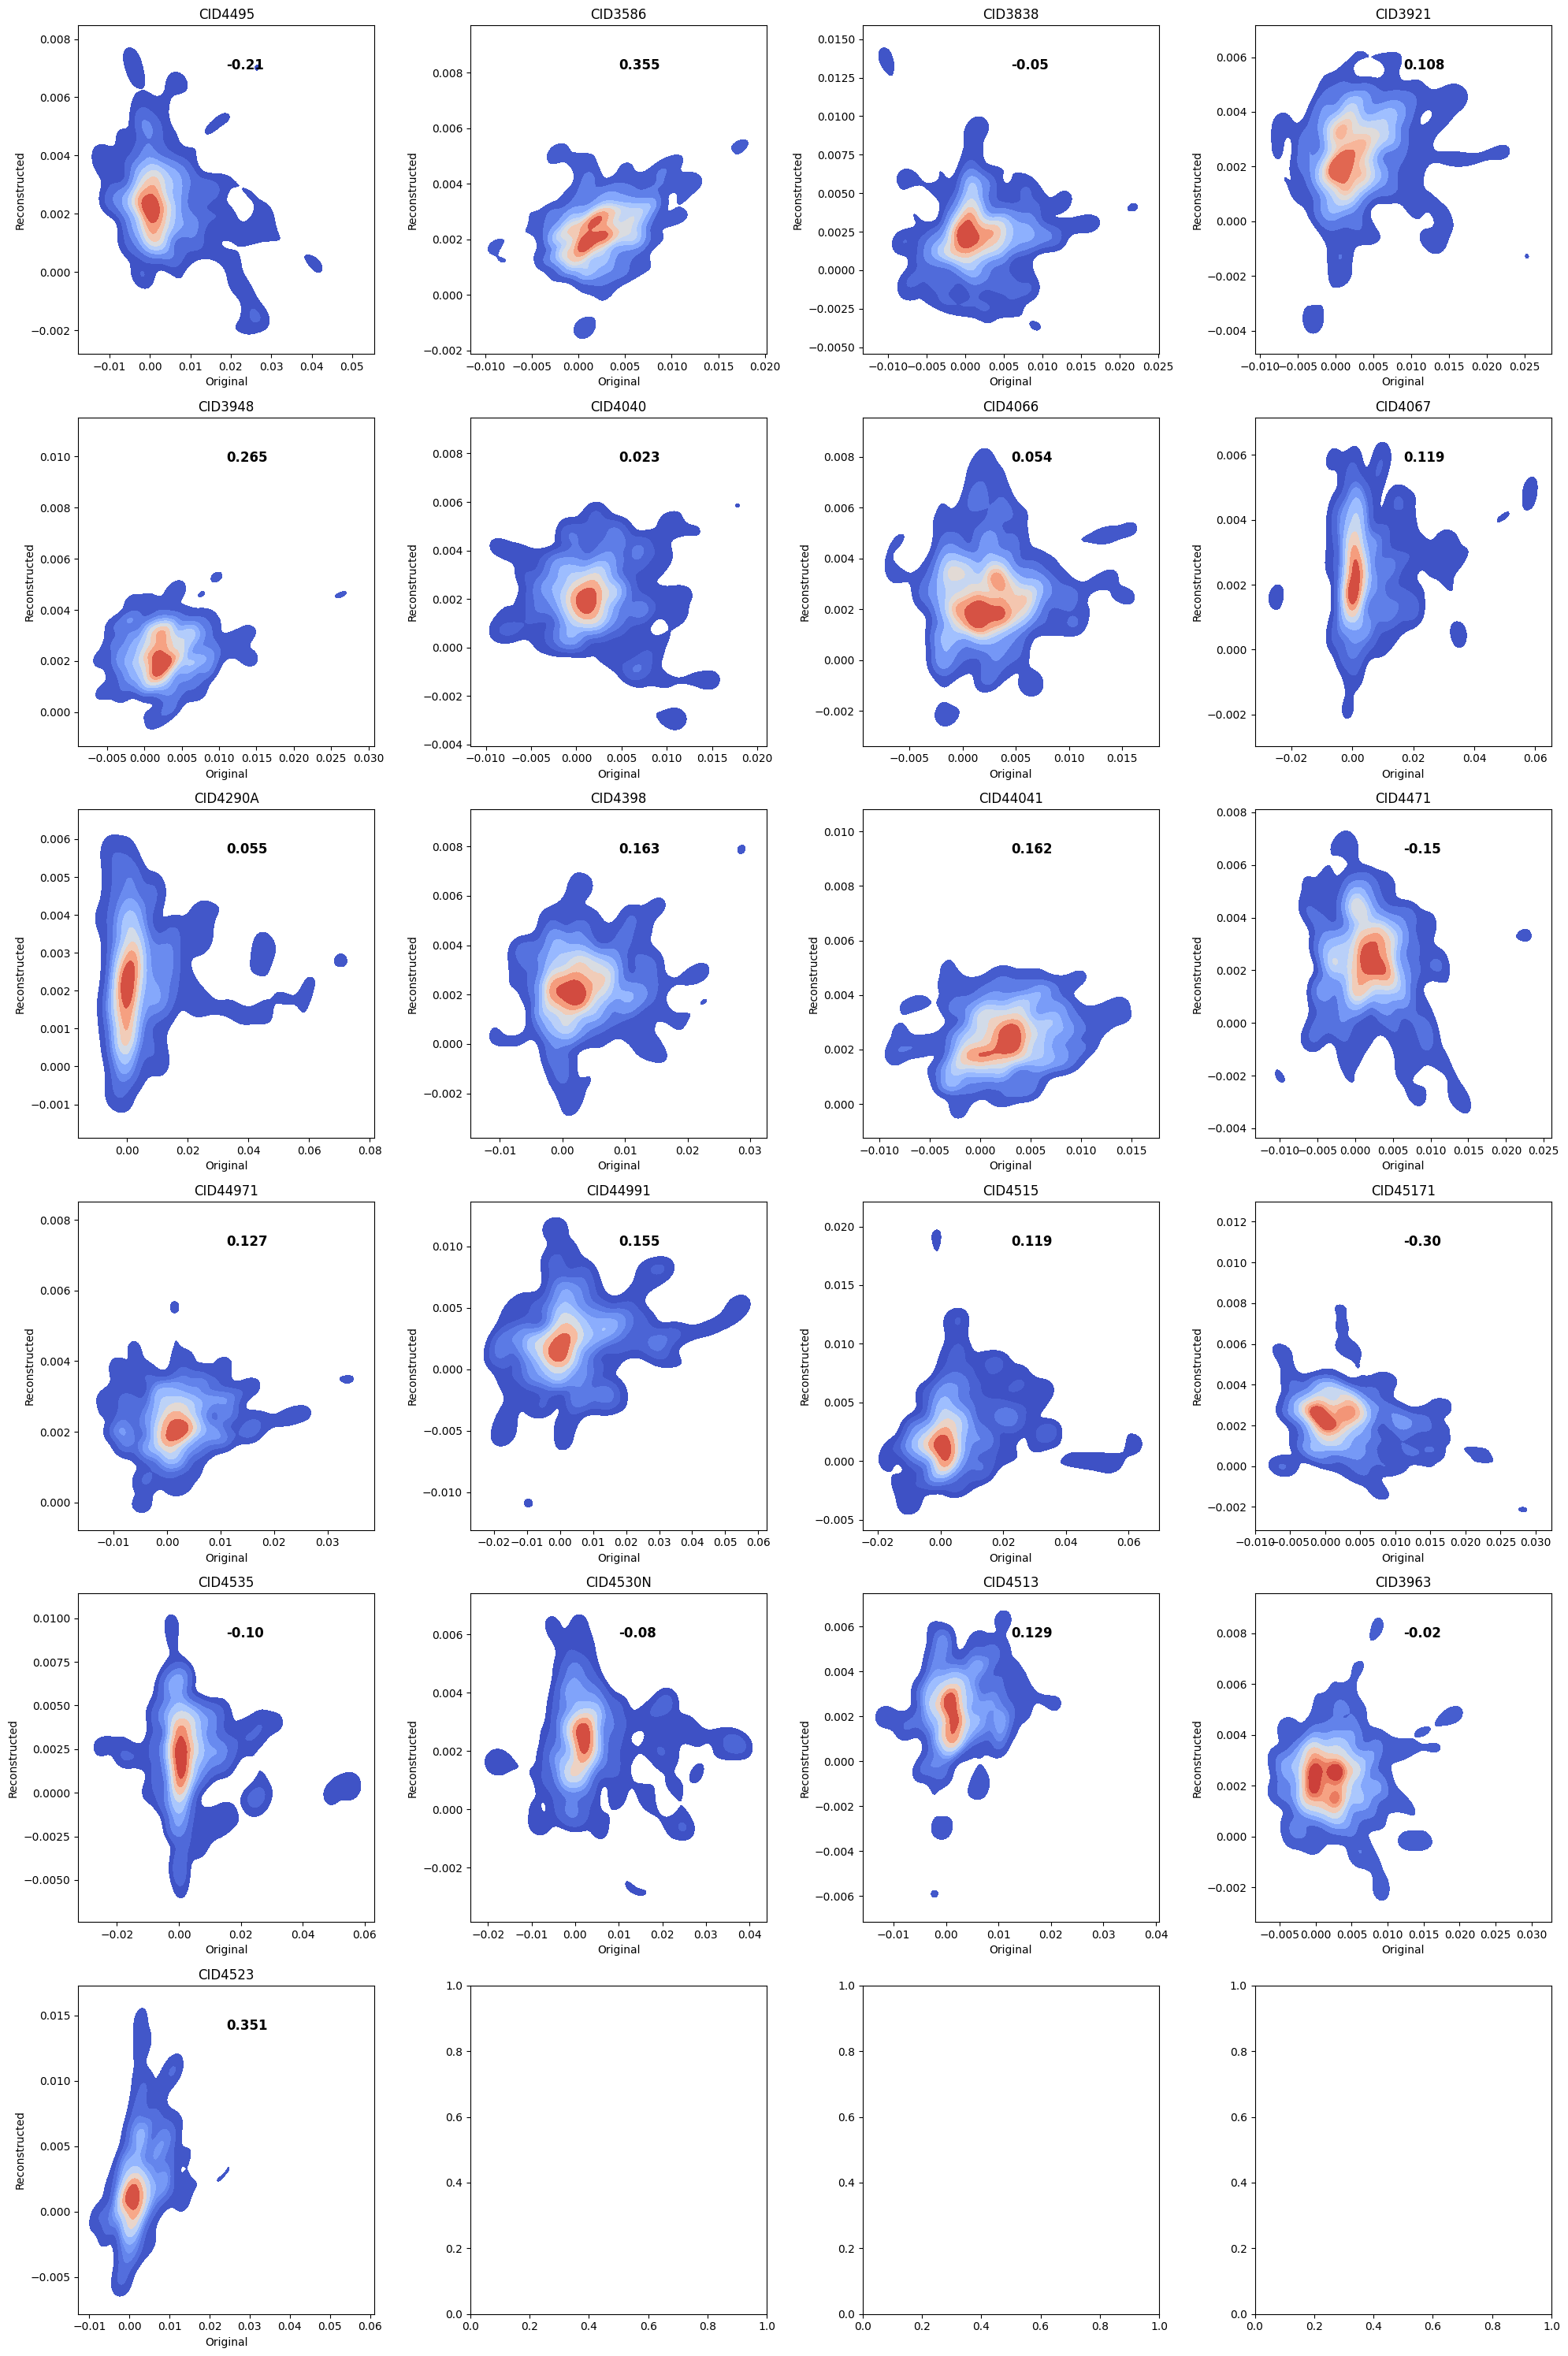

In [6]:

df_obs = picasa_adata.obs.copy()
df_obs.index = [x.split('@')[0] for x in df_obs.index]
df_obs = df_obs.loc[df_org.index.values]

unique_patients = df_obs['batch'].unique()
cn = 4
rn = int(np.ceil(len(unique_patients) / cn))  

fig, axes = plt.subplots(rn, cn, figsize=(20, 30))

for idx, p in enumerate(unique_patients):
    
    row, col = divmod(idx, cn)

    cells = df_obs.loc[df_obs['batch']==p].index.values

    org_vals = df_org.loc[cells,:].mean().values
    rec_vals = df_rec.loc[cells,:].mean().values
    
    corval = str(np.corrcoef(org_vals,rec_vals)[0,1])[:5]
        
    df_plot = pd.DataFrame({
        'Original': org_vals,
        'Reconstructed': rec_vals
    })

    ax = sns.kdeplot(
        data=df_plot, 
        x="Original", 
        y="Reconstructed", 
        cmap="coolwarm",  
        levels=10,
        ax = axes[row,col],
        fill=True  
    )
    
    axes[row, col].set_title(p)
    axes[row, col].text(
        0.5, 0.9, corval, 
        transform=axes[row, col].transAxes, 
        fontsize=12, 
        color='black', 
        weight='bold', 
        ha='left', va='top'
    )
    
plt.tight_layout()
